# SU(2) spin-$s$ Dicke state $|D^{(s)}_{n,k}\rangle$ preparation: QPE - $O(log(n))$ depth

Cirq implementation of a circuit in:

"Simple ways of preparing qudit Dicke states", https://arxiv.org/abs/2507.13308

by Noah B. Kerzner, Federico Galeazzi and Rafael I. Nepomechie

Code written by Noah Kerzner

In [2]:
pip install cirq

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cirq
import numpy as np
from collections import Counter
from scipy.special import comb
from scipy.linalg import expm



class R_ij(cirq.Gate):
    """Generilzed rotation gate 

    """    

    def __init__(self, theta: float, d: int, i: int, j: int):
        """initialzier for rotation gate 

        Args:
            theta (float): angle of rotation
            d (int): dimension of rotated qudits 
            i (int): begining state
            j (int): state to be rotated into 
        """        
        super().__init__()
        self.theta = theta
        self.d = d
        self.i = i
        self.j = j

    def _qid_shape_(self):
        return (self.d,)

    def _unitary_(self):
        mat = np.eye(self.d, dtype=np.complex128)
        i, j = self.i, self.j
        c = np.cos(self.theta/2)
        s = np.sin(self.theta/2)
        mat[i, i] = c
        mat[j, j] = c
        mat[i, j] = -s
        mat[j, i] = s
        return mat

    def _circuit_diagram_info_(self, args):
        return f"R({self.i},{self.j},{self.theta:.2f})"






def full_U(k:int,l:int,d:int,n:int, anc_qubs: list[cirq.LineQubit], working_vec: cirq.LineQid):
    
    h_k=np.array(np.diag([i for i in range(d)]))

    for p, qub in enumerate(anc_qubs):

        for i in range(n):

            

            U=expm(2j * np.pi * h_k / (2**l)*(2**(l - p - 1)))
            
            
            yield cirq.ControlledGate(
                cirq.MatrixGate(U,name=f"U_^{(2**(l - p - 1))}",qid_shape=(d,)),
                control_values=(1,),
                control_qid_shape=(2,)
            ).on(qub, working_vec[i])



def qpe(k:int, num_qubs: int, d: int,n:int,  working_vec: list[cirq.Qid], mode=0):


    anc_quds=[]


  
    for j in range(num_qubs):
        anc_quds.append(cirq.LineQubit(j))
 

    
    # Apply Hadamards to ancillas
    for qud in anc_quds:
        yield cirq.H.on(qud)

    #Apply controlled-U^{d^i}

    yield full_U(k,num_qubs,d,n,anc_quds,working_vec)


    yield cirq.qft(*anc_quds, inverse=True)


    if mode==0: # mode to measure or not 
        # Measure

        yield cirq.measure(*anc_quds, key='k_estimate')
        
        yield cirq.measure(working_vec,key='dicke')



def ditgamma(s,k,n,m):
    """gamma factor for qdit dicke state 

    Args:
        n (int): num qdits
        k (int): amount of spin ops applied 
        l (int): current ancilery qudit value/ I gate index 
        m (int): value of working qudit (not anciliry)
        s (float): spin of system

    Returns:
        float: gamma value 
    """    
    
    p=k/(2*s*n)
    val=(1-p)**s
    val*=np.sqrt(comb(2*s,m))
    val*=(p/(1-p))**(m/2)
    return val



def get_dit_thetas(n, k, s):
    thetas = []
    epsilon = 1e-10

    theta_1 = 2 * np.arccos(np.clip(ditgamma(s, k, n, 0), -1, 1))
    thetas.append(theta_1)

    for m in range(1, int(2 * s)):
        denom = list_prod(thetas)
        if abs(denom) < epsilon:
            thetas.extend([0 for _ in range(int(2 * s - len(thetas)))])
            return thetas

        bin_expr = ditgamma(s, k, n, m) / denom
        bin_expr = np.clip(bin_expr, -1, 1)
        theta_m = 2 * np.arccos(bin_expr)

        if np.isnan(theta_m):  # safety check
            thetas.extend([0 for _ in range(int(2 * s - len(thetas)))])
            return thetas

        thetas.append(theta_m)

    return thetas


def list_prod(arr):
    ret=1

    for arg in arr:
        ret*=np.sin(arg/2)
    return ret



def dicke_simulate(n:int,k: int, s: float):
    """
    runs the qpe algo for the dicke state but does not measure.

    - The function ouptuts the final state pre measurment of the total system
    - the order is ancilary qubits then working qubits

    Args:
        n (int): number of working qubits
        k (int): desired number of 1's in dicke state
    """


   

    d=int(2*s+1)

    l = int(np.ceil(np.log((d-1)*n + 1)/np.log(2)))

    

    quds=[]
    for i in range(n):
        quds.append(cirq.LineQid(l+i,dimension=d))

    circuit=cirq.Circuit()


    thetas=get_dit_thetas(n,k,s)

    for i,theta in enumerate(thetas):  
        R=R_ij(theta,d,i,i+1)
        for qud in quds: 
            circuit.append(R.on(qud))

    circuit.append(qpe(k,l,d,n,quds,1))

    # Simulate
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    print(circuit)
    print(cirq.dirac_notation(result.final_state_vector, qid_shape=(2,) * (l) + (d,)*n))



def dicke_shots(n,k,s,shots=10,mode=0): # mode=0 for full distrobution, mode = 1 for expected k distrobution
    """runs repeated qpe alogirthm to make bar graph of final vector measurment and l

    - Mode = 0 prints a bar graph of the total probability distrobution (all k's and all state vectors)
    - Mode = 1 prints a bar graph of the probabiliyt distrobution only for the measurments in the expected k

    Args:
        n (_type_): amount of working qubits
        k (_type_): desired number of 1's 
        shots (int, optional): amount of instances of the QPE algorithm. Defaults to 10.
        mode (int, optional): mode of operation. Defaults to 0.
    """    
    
    d=int(2*s+1)

    l = int(np.ceil(np.log((d-1)*n + 1)/np.log(2)))

    

    quds=[]
    for i in range(n):
        quds.append(cirq.LineQid(l+i,dimension=d))

    circuit=cirq.Circuit()


    thetas=get_dit_thetas(n,k,s)

    for i,theta in enumerate(thetas):  
        R=R_ij(theta,d,i,i+1)
        for qud in quds: 
            circuit.append(R.on(qud))

    circuit.append(qpe(k,l,d,n,quds,0))

    # Simulate
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=shots)


    bitstrings = ["".join(str(bit) for bit in bits) for bits in result.measurements['k_estimate']]
    
    counts = Counter(bitstrings)
    most_common_k = counts.most_common(1)[0][0]
    #print(counts)
    estimated_k = int(most_common_k, 2)
    dicke_bits = result.measurements['dicke']
    if mode == 1:
        dickes_meas = [
        "".join(str(bit) for bit in bits)
        for bits in dicke_bits
        if sum(int(b) for b in bits) == k  # keep only bitstrings where the digit sum equals k
    ]
    else:
        dickes_meas = ["".join(str(bit) for bit in bits) for bits in dicke_bits]

    dickes=Counter(dickes_meas)
    analyze_counters(dickes, estimated_k)


def analyze_counters( dickes: Counter, estimated_k: int):
    """Function to make bar graph of measurment results

    Args:
        counter2 (Counter): counted and ordered dicke measrument results 
        estimated_k (int): most probable k from measurment
    """    
    # Print most common value from counter1

    #print(estimated_k, 'k val')
    # Plot histogram from counter2
    labels, values = zip(*dickes.items())
    plt.bar(labels, values)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title(f'Distribution of final state vectors for k ≈ {estimated_k}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Examples

In [11]:
# Example without measurement

# For dicke simulate pass function as dicke_simulate(n,k,s)
dicke_simulate(3,2,1)

# The target state, expressed in Dirac notation, is given in this example by
#
# |k⟩|D^s_{n,k}⟩ =|2⟩|D^1_{3,2}⟩ = |010⟩ (0.26|002⟩ + 0.52|011⟩ + 0.26|020⟩ + 0.52|101⟩ + 0.52|110⟩ + 0.26|200⟩)
#
# = 0.26|010002⟩ + 0.52|010011⟩ + 0.26|010020⟩ + 0.52|010101⟩ + 0.52|010110⟩ + 0.26|010200⟩
#
# Note, however, that this algorithm prepares a superposition of all Dicke states k=0, 1, ..., 6
# The ancillas must still be measured, with success on |k⟩=|2⟩=|010⟩, in order to project to the target state.


                                               ┌────────┐   ┌────────────┐   ┌────────┐
0: ─────────H───────────────────────────@───────@────────────@───────────────────────────────────qft^-1───
                                        │       │            │                                   │
1: ─────────H───────────────────────────┼───────┼───@────────┼───@────────────@──────────────────#2───────
                                        │       │   │        │   │            │                  │
2: ─────────H───────────────────────────┼───────┼───┼────────┼───┼───@────────┼───@───────@──────#3───────
                                        │       │   │        │   │   │        │   │       │
3 (d=3): ───R(0,1,1.68)───R(1,2,0.93)───U_^4────┼───U_^2─────┼───┼───U_^1─────┼───┼───────┼───────────────
                                                │            │   │            │   │       │
4 (d=3): ───R(0,1,1.68)───R(1,2,0.93)───────────U_^4─────────┼───U_^2─────────┼───U_^1────┼───────────

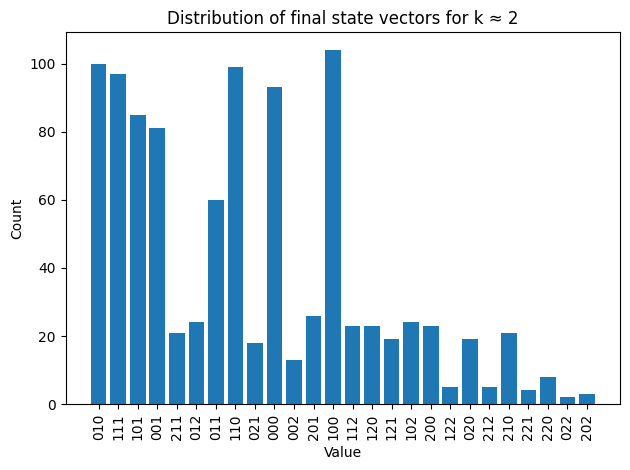

In [12]:
# Example with measurement 

# For dicke shots pass function as dicke_shots(n,k,s,shots, *optional* mode)
dicke_shots(3,2,1,1000)
